In [1]:
import numpy as np
from scipy.special import gammainc, gamma
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.integrate import quad
from scipy.stats import poisson
from tqdm import tqdm   
from random import choices
from collections import Counter

## Juan Notes:
* I would like a docstring for how singleAtom works. We've been using the google standard for dev on the cspy project, looks like we'll be adopting it as a lab so use that.
    - google standard styleguide, info on docstrings is section 3.8 : http://google.github.io/styleguide/pyguide.html
    - google standard examples : https://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_google.html
* units for values set?
* the first term in your lambda function is causing decays of counts to zero. They need to decay into the background rate
* I like what you've done here, but I would like to be able to understand at a glance. Could you put a latex explanation of the math you're doing up here?

In [33]:
#define the variables that determine how many photons are released
recordTime = .003
rateSingleAtom = 145000
rateBackground = 100000
lifetimeOfTrap = 1

#up to this many photons
countEnd = 700
xx = np.arange(countEnd)
#the background is just a poisson distribution
probDistBack = poisson.pmf(xx,recordTime*rateBackground)
#the single atom is a poisson distribution with a lifetime of 1/e 
def singleAtom(recordTime,rate,lifeTime,xx):
    prob = []
    for i in tqdm(xx):
        #take the integral of the lifetime and the poisson dist 
        val = quad(
            lambda t,r,n,ts,tau:np.exp(-t/tau)/tau*poisson.pmf(n,r*t)+np.exp(-ts/tau)*poisson.pmf(n,r*ts),
            0,
            recordTime,
            args = (rate,i,recordTime, lifeTime) 
        )[0] 
        prob.append(val) 
    #return the prob dist for all of the photon counts in xx
    return prob





In [34]:
#get the distribution, the integrals take longer then the rest of the code
probDistSingle = singleAtom(recordTime,rateSingleAtom,lifetimeOfTrap,xx)


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:13<00:00, 51.70it/s]


In [39]:
#get a histogram with N datapoints
hist = [] 
N = 5000
population = [0,1] #0 is no atom, 1 is single atome
#the prob of loading an atom
weights = [.5,.5]
samples = choices(population,weights,k = N)

for i in samples:
    if i == 0:
        #do background rate
        hist.append(choices(xx,probDistSingle)[0])
    else:
        #do single atom rate
        hist.append(choices(xx,probDistBack)[0])

## Juan Notes:
* Decay from single atom should only decay down to background rate, not zero!
* Plot labels?

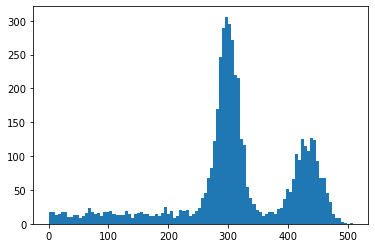

In [40]:
plt.hist(hist,100)
plt.show()

## Juan Notes:
* The integration takes a long time. I found simulating the atom statistics is really fast comparatively. Could you simulate the same physics without integrating the complicated equation above and instead simulating atom loss during a measurement many times??